# **Exercise 7.04**
# **Building a Convolutional Neural Network with Additional Convolutional Layers**

You'll do this by building a horses-or-humans classifier that will tell you if a given image contains a horse or a human, where the network is trained to recognize features that determine which is which.


**Import libraries.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop
from keras_preprocessing import image as kimage
tf.config.run_functions_eagerly(True)

In [ ]:
(our_train_dataset, our_test_dataset), \
dataset_info = tfds.load(
                         'horses_or_humans'
                          , split = ['train', 'test']
                          , data_dir = 'content/'
                          , shuffle_files = True
                          , with_info = True)
assert isinstance(our_train_dataset, tf.data.Dataset)

In [3]:
image_shape = dataset_info.features["image"].shape
names_of_classes = dataset_info.features["label"].names

our_cnn_model = models.Sequential([
    layers.Conv2D(filters = 16, kernel_size = (3,3), \
                  input_shape = image_shape)
    , layers.Activation('relu')
    , layers.MaxPool2D(pool_size = (2, 2))

    , layers.Conv2D(filters = 32, kernel_size = (3,3))
    , layers.Activation('relu')
    , layers.MaxPool2D(pool_size = (2, 2))

    , layers.Flatten()
    , layers.Dense(units = 512)
    , layers.Activation('relu')
    , layers.Dense(units = 1)
    , layers.Activation('sigmoid')
])


In [ ]:
our_cnn_model.compile(
                      optimizer=RMSprop(learning_rate=0.001), \
                      loss='binary_crossentropy',
                      metrics=['acc'], loss_weights=None,
                      weighted_metrics=None, run_eagerly=None,
                      steps_per_execution=None
)


**Data preprocessing**


In [5]:

normalization_layer = layers.Rescaling(1./255)
our_train_dataset = our_train_dataset.map(lambda x: (normalization_layer(x['image']), x['label']), num_parallel_calls =  tf.data.experimental.AUTOTUNE)
our_train_dataset = our_train_dataset.cache()
our_train_dataset = our_train_dataset.shuffle\
                    (len(our_train_dataset))
our_train_dataset = our_train_dataset.batch(128)
our_train_dataset = \
our_train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

our_test_dataset = our_test_dataset.map(lambda x: (normalization_layer(x['image']), x['label'])
                    , num_parallel_calls =  tf.data.experimental.AUTOTUNE)
our_test_dataset = our_test_dataset.cache()
our_test_dataset = our_test_dataset.batch(32)
our_test_dataset = our_test_dataset.prefetch\
                   (tf.data.experimental.AUTOTUNE)


**Fit our model.**

In [6]:
tf.config.run_functions_eagerly(True)
history = our_cnn_model.fit(\
          our_train_dataset, \
          validation_data = our_test_dataset, \
          epochs=15, \
          validation_steps=8, \
          verbose=1)


2021-11-24 11:26:16.668040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
9/9 [==============================] - 41s 4s/step - loss: 15.1933 - acc: 0.5307 - val_loss: 3.2516 - val_acc: 0.5000
Epoch 2/15
9/9 [==============================] - 40s 4s/step - loss: 0.6955 - acc: 0.7975 - val_loss: 1.3275 - val_acc: 0.6523
Epoch 3/15
9/9 [==============================] - 41s 5s/step - loss: 0.0899 - acc: 0.9718 - val_loss: 1.4754 - val_acc: 0.6797
Epoch 4/15
9/9 [==============================] - 40s 4s/step - loss: 0.0383 - acc: 0.9932 - val_loss: 1.8098 - val_acc: 0.6914
Epoch 5/15
9/9 [==============================] - 37s 4s/step - loss: 0.0184 - acc: 0.9971 - val_loss: 2.2357 - val_acc: 0.6953
Epoch 6/15
9/9 [==============================] - 41s 5s/step - loss: 0.5430 - acc: 0.8500 - val_loss: 1.9197 - val_acc: 0.6797
Epoch 7/15
9/9 [==============================] - 40s 4s/step - loss: 0.0499 - acc: 0.9912 - val_loss: 2.2174 - val_acc: 0.7422
Epoch 8/15
9/9 [==============================] - 49s 6s/step - loss: 0.0201 - acc: 0.9961 - val_loss: 

**Check our predictions.**

[[0.9993913]]
Image is a human


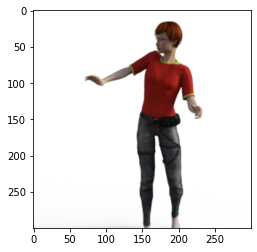

In [7]:
import matplotlib.pyplot as plt

for images, lables in our_test_dataset.take(1):
    plt.imshow(np.asarray(images[0]))
    image_to_test = kimage.img_to_array(images[0])
    image_to_test = np.array([image_to_test])

    prediction = our_cnn_model.predict(image_to_test)
    print(prediction)
    if prediction > 0.5:
        print("Image is a human")
    else:
        print("Image is a horse")


**Visualizing representations.**

/var/folders/v0/795n8g_54hg_pf1m9gp9xtj40000gn/T/ipykernel_59212/2298212694.py:24: RuntimeWarning: invalid value encountered in true_divide
  img = ((((img - img.mean()) / img.std()) * 64) + 128)


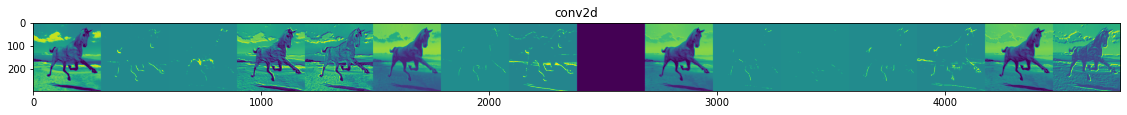

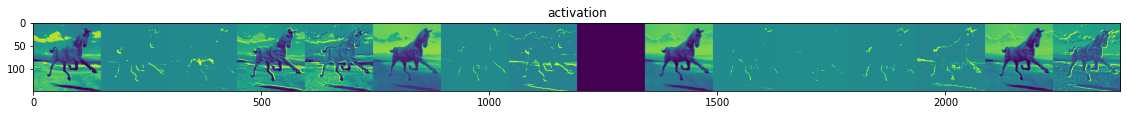

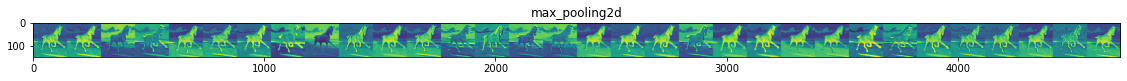

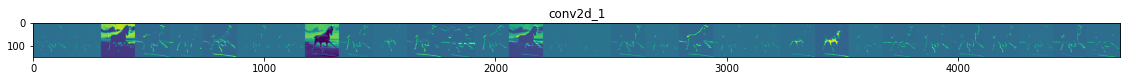

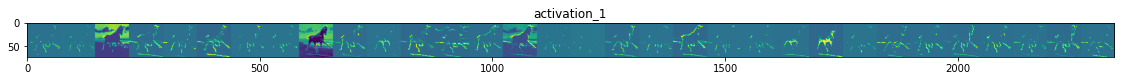

In [8]:
layer_outputs = []
for layer in our_cnn_model.layers[1:]:
    layer_outputs.append(layer.output)
layer_names = []
for layer in our_cnn_model.layers:
    layer_names.append(layer.name)

features_model = models.Model(inputs = our_cnn_model.input, \
                              outputs = layer_outputs)
random_sample = our_train_dataset.take(1)

layer_predictions = features_model.predict(random_sample)

for layer_name, prediction in zip(layer_names, \
                                  layer_predictions):
    if len(prediction.shape) != 4:
        continue
    num_features = prediction.shape[-1]
    size = prediction.shape[1]
    grid = np.zeros((size, size * num_features))

    for i in range(num_features):
        img = prediction[0, :, :, i]
        img = ((((img - img.mean()) / img.std()) * 64) + 128)
        img = np.clip(img, 0, 255).astype('uint8')
        grid[:, i * size : (i + 1) * size] = img

    scale = 20. / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.title(layer_name)
    plt.imshow(grid)
